## Imports

In [1]:
import torch
import os
import json
import matplotlib.pyplot as plt

In [2]:
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [3]:
%run ../iu_xray.py

In [4]:
REPORTS_DIR = os.path.join(DATASET_DIR, 'reports')

## Apply chexpert labeler to reports

In [ ]:
%run -n ../../eval_report_generation_chexpert_labeler.py

In [51]:
fname = os.path.join(REPORTS_DIR, 'reports.clean.json')
with open(fname, 'r') as f:
    clean_reports = list(json.load(f).values())
len(clean_reports)

3826

In [52]:
reports_by_filename = {
    r['filename']: r['clean_text']
    for r in clean_reports
}
len(reports_by_filename)

In [ ]:
df_reports = pd.DataFrame(reports_by_filename, columns=['reports'])
print(len(df_reports))
df_reports.head()

In [ ]:
%%time

labels = _apply_labeler_to_column(df_reports, 'reports',
                                  fill_empty=-2, fill_uncertain=-1)
labels.shape

In [ ]:
df_reports = _concat_df_matrix(df_reports, labels)
df_reports.head()

## Apply MIRQI labeler to reports

In [111]:
from collections import defaultdict

In [36]:
%run -n ../../eval_report_generation_mirqi.py

In [40]:
path = os.path.join(REPORTS_DIR, 'reports_with_chexpert_labels.csv')
df = pd.read_csv(path, index_col=0)
df = df[['Reports', 'filename']]
df.head()

,Reports,filename
0,the cardiac silhouette and mediastinum size ar...,1.xml
1,the cardiomediastinal silhouette is within nor...,10.xml
2,both lungs are clear and expanded . heart and ...,100.xml
3,there is xxxx increased opacity within the rig...,1000.xml
4,interstitial markings are diffusely prominent ...,1001.xml


In [98]:
%%time

mirqi_df = _apply_mirqi_to_df(df, gt_col_name='Reports', gen_col_name='Reports')
mirqi_df.head()

Evaluating reports with MIRQI...
	Calling ~/software/miniconda3/envs/chexpert-label/bin/python evaluate.py --reports_path_gt /mnt/workspace/medical-ai/tmp/mirqi/gt-input.csv --reports_path_cand /mnt/workspace/medical-ai/tmp/mirqi/gen-input.csv --output_path /mnt/workspace/medical-ai/tmp/mirqi/output.csv 
CPU times: user 159 ms, sys: 12.4 ms, total: 172 ms
Wall time: 31min 47s


,Reports,filename,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f
0,the cardiac silhouette and mediastinum size ar...,1.xml,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0
1,the cardiomediastinal silhouette is within nor...,10.xml,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,1.0,1.0,1.0
2,both lungs are clear and expanded . heart and ...,100.xml,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0
3,there is xxxx increased opacity within the rig...,1000.xml,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0
4,interstitial markings are diffusely prominent ...,1001.xml,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1.0,1.0,1.0


In [112]:
valoration_to_int = {
    'POSITIVE': 1,
    'NEGATIVE': 0,
    'UNCERTAIN': -1,
}

WRONG_LEN_ATTRIBUTES = defaultdict(list)

def expand_attributes(row):
    attributes = row['attributes-gt']
    attributes = [s.strip('()') for s in attributes.split(') (')]
    attributes = [s.split('|') for s in attributes]
    
    for tup in attributes:
        if len(tup) != 4:
            WRONG_LEN_ATTRIBUTES['len-not-4'].append(tup)
            continue
        text, label, value, additional = tup
        row[label] = valoration_to_int[value]
        
    return row

In [113]:
mirqi_df = mirqi_df.apply(expand_attributes, axis=1)
mirqi_df.head()

,Airspace Disease,Airspace Opacity,Atelectasis,Calcinosis,Cardiomegaly,Consolidation,Edema,Emphysema,Enlarged Cardiomediastinum,Fracture,...,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Reports,Scoliosis,Support Devices,attributes-gen,attributes-gt,filename
0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,...,0.0,NaN,NaN,0.0,the cardiac silhouette and mediastinum size ar...,NaN,NaN,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.xml
1,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,...,0.0,NaN,NaN,0.0,the cardiomediastinal silhouette is within nor...,NaN,NaN,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,10.xml
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,both lungs are clear and expanded . heart and ...,NaN,NaN,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,100.xml
3,-1.0,-1.0,-1.0,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,there is xxxx increased opacity within the rig...,NaN,NaN,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1000.xml
4,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,interstitial markings are diffusely prominent ...,NaN,NaN,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1001.xml


In [117]:
base_cols = ['filename', 'Reports', 'attributes-gt', 'attributes-gen', 'MIRQI-r', 'MIRQI-p', 'MIRQI-f']
columns = base_cols + [c for c in mirqi_df if c not in base_cols]
mirqi_df = mirqi_df[columns]
mirqi_df.head()

,filename,Reports,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f,Airspace Disease,Airspace Opacity,Atelectasis,...,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
1,10.xml,the cardiomediastinal silhouette is within nor...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,1.0,1.0,1.0,0.0,0.0,NaN,...,NaN,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN
2,100.xml,both lungs are clear and expanded . heart and ...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000.xml,there is xxxx increased opacity within the rig...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,NaN,NaN,-1.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,1001.xml,interstitial markings are diffusely prominent ...,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1.0,1.0,1.0,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
mirqi_df.replace(np.nan, -2, inplace=True)
mirqi_df.head()

,filename,Reports,attributes-gt,attributes-gen,MIRQI-r,MIRQI-p,MIRQI-f,Airspace Disease,Airspace Opacity,Atelectasis,...,Hernia,Hypoinflation,Lung Lesion,Other Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Scoliosis,Support Devices
0,1.xml,the cardiac silhouette and mediastinum size ar...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0
1,10.xml,the cardiomediastinal silhouette is within nor...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,(contour|Enlarged Cardiomediastinum|NEGATIVE|)...,1.0,1.0,1.0,0.0,0.0,-2.0,...,-2.0,-2.0,-2.0,1.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0
2,100.xml,both lungs are clear and expanded . heart and ...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,( mediastinum|Enlarged Cardiomediastinum|NEGAT...,1.0,1.0,1.0,-2.0,-2.0,-2.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,1000.xml,there is xxxx increased opacity within the rig...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,(mass|Lung Lesion|UNCERTAIN|possible) (consoli...,1.0,1.0,1.0,-1.0,-1.0,-1.0,...,-2.0,-2.0,-1.0,-2.0,0.0,-2.0,-2.0,0.0,-2.0,-2.0
4,1001.xml,interstitial markings are diffusely prominent ...,(interstitial markings|Other Finding|POSITIVE|...,(interstitial markings|Other Finding|POSITIVE|...,1.0,1.0,1.0,-2.0,1.0,-2.0,...,-2.0,-2.0,-2.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [119]:
path = os.path.join(REPORTS_DIR, 'reports_with_mirqi_labels.csv')
mirqi_df.to_csv(path)

## Split sentences

In [51]:
%run ../../utils/nlp.py

In [52]:
from collections import Counter, defaultdict

In [53]:
def split_sentences(report, end_token='.'):
    report = report.split()
    if report[-1] != end_token:
        report.append(end_token)

    sentences = []
    sentence = []
    for word in report:
        sentence.append(word)
        if word == end_token:
            sentences.append(sentence)
            sentence = []
            
    return [' '.join(s) for s in sentences]

### Load reports

In [54]:
reports_fname = os.path.join(REPORTS_DIR, 'reports.clean.v2.json')
with open(reports_fname, 'r') as f:
    reports_as_dict = json.load(f)
    reports = list(reports_as_dict.values())
len(reports_as_dict), len(reports)

(3826, 3826)

### Count appearances

In [55]:
sentence_counter = defaultdict(list)
for report in reports:
    for sentence in split_sentences(report['clean_text']):
        sentence_counter[sentence].append(report['filename'])
len(sentence_counter)

6448

In [56]:
l = list(sentence_counter.items())
l = sorted(l, key=lambda x: x[1], reverse=True)
l[:20]

[('cardiomediastinal silhouette demonstrates normal heart size with tortuosity and atherosclerosis of the thoracic aorta .',
  ['998.xml']),
 ('multilevel degenerative disc disease of the thoracic spine noted .',
  ['998.xml']),
 ('calcified mediastinal xxxx .', ['997.xml']),
 ('no pneumothorax , effusion , or pneumonia .', ['996.xml']),
 ('sternotomy sutures and bypass grafts have been placed in the interval .',
  ['995.xml']),
 ('both lungs remain clear and expanded with no infiltrates .', ['995.xml']),
 ('there are bilateral pulmonary nodules whose appearances suggest metastatic disease to lungs .',
  ['992.xml']),
 ('in the right lung , there is a NUMBER x NUMBER cm nodule overlying the posterior right\x01 NUMBER rib .',
  ['992.xml']),
 ('there is a NUMBER x NUMBER cm nodule xxxx above this in the interspace between the posterior\x01 NUMBER and\x01 NUMBER ribs on the right .',
  ['992.xml']),
 ('there is a NUMBER x NUMBER cm nodule projecting through the left\x01 NUMBER and\x01 NU

### Inspect broken sentences

In [57]:
import re

In [58]:
starts_with_number = re.compile('^\d')

In [59]:
[
    (s, filenames)
    for s, filenames in sentence_counter.items()
    if starts_with_number.search(s)
]

[('2 images .',
  ['1131.xml',
   '1234.xml',
   '1270.xml',
   '1382.xml',
   '1630.xml',
   '1766.xml',
   '1846.xml',
   '1963.xml',
   '2389.xml',
   '2584.xml',
   '2730.xml',
   '3130.xml',
   '3210.xml',
   '3795.xml',
   '539.xml',
   '64.xml',
   '680.xml',
   '741.xml',
   '81.xml']),
 ('4 images .', ['1525.xml']),
 ('3 images .', ['1643.xml', '3858.xml']),
 ('3 cm right upper lobe anterior segment mass .', ['2455.xml']),
 ('13 -\x01 NUMBER mm ring-shaped opacity with central lucency , seen with certainty on pa view only , projects over right midlung .',
  ['2750.xml']),
 ('2 views of the chest demonstrate sternotomy xxxx and mild thoracic dextroscoliosis .',
  ['3684.xml']),
 ('3 cm calcified right paratracheal lymph node .', ['61.xml'])]

In [60]:
reports_as_dict['1337.xml']['clean_text']

'low lung volumes . exam limited on lateral view by superimposed soft tissue and bony structures of the arm . lungs appear grossly clear . no evidence of pneumonia . heart and pulmonary xxxx appear normal . pleural spaces are clear . mediastinal contours appear normal . no acute cardiopulmonary disease on this exam .'

## Label sentences with chexpert labels

In [1]:
%run -n ../../eval_report_generation_chexpert_labeler.py

In [10]:
columns = ['sentences', 'appearances']
df_sentences = pd.DataFrame(list(sentence_counter.items()), columns=columns)
print(len(df_sentences))
df_sentences.head()

6448


,sentences,appearances
0,the cardiac silhouette and mediastinum size ar...,6
1,there is no pulmonary edema .,12
2,there is no focal consolidation .,34
3,there are no xxxx of a pleural effusion .,3
4,there is no evidence of pneumothorax .,23


In [11]:
%%time

labels = _apply_labeler_to_column(df_sentences, 'sentences',
                                  fill_empty=-2, fill_uncertain=-1)
labels.shape

Labelling sentences...
CPU times: user 61.7 ms, sys: 20.5 ms, total: 82.2 ms
Wall time: 9min 28s


(6448, 14)

In [13]:
df_sentences = _concat_df_matrix(df_sentences, labels)
print(len(df_sentences))
df_sentences.head()

6448


,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,there is no pulmonary edema .,12,1.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,there is no focal consolidation .,34,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,there are no xxxx of a pleural effusion .,3,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0
4,there is no evidence of pneumothorax .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0


In [17]:
fpath = os.path.join(REPORTS_DIR, 'sentences_with_chexpert_labels.csv')

In [18]:
df_sentences.to_csv(fpath, index=False)

## Load sentences for later use

In [6]:
import pandas as pd

In [7]:
fpath = os.path.join(REPORTS_DIR, 'sentences_with_chexpert_labels.csv')

In [8]:
df_sentences = pd.read_csv(fpath)
df_sentences.head()

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,there is no pulmonary edema .,12,1.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,there is no focal consolidation .,34,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,there are no xxxx of a pleural effusion .,3,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0
4,there is no evidence of pneumothorax .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0


## Count sentences' groups

### Count normal vs abnormal

In [50]:
snt_normal = df_sentences[df_sentences['No Finding'] == 1]
snt_abnormal = df_sentences[df_sentences['No Finding'] == 0]
len(snt_normal), len(snt_abnormal)

(3306, 3142)

In [54]:
snt_normal['appearances'].sum()

13302

In [56]:
snt_abnormal['appearances'].sum()

4231

### Number of abnormal sentences per report

In [65]:
is_sentence_normal = dict()
for index, row in df_sentences.iterrows():
    sentence = row['sentences']
    is_normal = row['No Finding']
    is_sentence_normal[sentence] = is_normal
len(is_sentence_normal)

6448

In [69]:
res = []
for report in reports:
    number_of_abnormal = sum(
        1 - is_sentence_normal[sentence]
        for sentence in split_sentences(report['clean_text'])
    )
    res.append(number_of_abnormal)
len(res)

3826

(array([1.502e+03, 1.176e+03, 6.420e+02, 3.320e+02, 0.000e+00, 1.220e+02,
        3.100e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

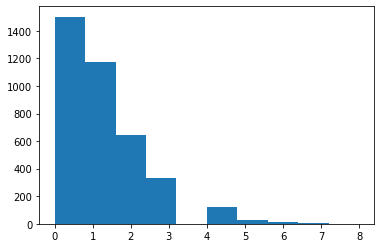

In [70]:
plt.hist(res)

### Top-K most common sentences

In [40]:
cols = ['sentences', 'appearances']
df = df_sentences[cols].sort_values('appearances', ascending=False).head(5)
df

,sentences,appearances
38,the lungs are clear .,357
100,no pneumothorax .,263
20,lungs are clear .,234
19,heart size normal .,180
161,no pneumothorax or pleural effusion .,176


### Plot sentences appearances distribution

In [24]:
len(df_sentences)

6448

In [20]:
df_sentences.sort_values('appearances', ascending=False).head()

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
38,the lungs are clear .,357,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,no pneumothorax .,263,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20,lungs are clear .,234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,heart size normal .,180,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,no pneumothorax or pleural effusion .,176,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
appearances = list(df_sentences['appearances'])

Text(0.5, 0, 'Number of appearances')

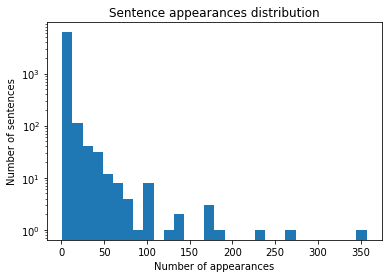

In [23]:
plt.hist(appearances, bins=30)
plt.yscale('log')

plt.title('Sentence appearances distribution')

plt.ylabel('Number of sentences')
plt.xlabel('Number of appearances')

<BarContainer object of 6448 artists>

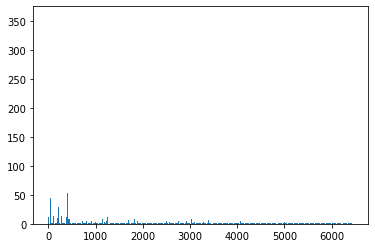

In [8]:
plt.bar(list(range(len(values))), values)

## Collect synonyms

In [35]:
import json
from collections import Counter, defaultdict

In [110]:
%run ../vocab/__init__.py

In [42]:
SYNONYMS = load_synonyms('iu_xray')
len(SYNONYMS)

{'the lungs are clear': ['lungs clear',
  'lungs are clear',
  'the lungs are clear bilaterally',
  'both lungs are clear and expanded',
  'clear lungs',
  'lungs are clear bilaterally',
  'the lungs appear clear'],
 'heart size normal': ['the heart size is normal',
  'heart size is normal',
  'the heart is normal in size',
  'heart size within normal limits',
  'normal heart size',
  'heart size is within normal limits',
  'normal heart',
  'heart size is now normal',
  'the heart is of normal size',
  'the heart is normal in size and contour',
  'the heart size is within normal limits',
  'the heart is normal size'],
 'no pneumothorax or pleural effusion': ['no pleural effusion or pneumothorax',
  'there is no pleural effusion or pneumothorax',
  'no pleural effusion or pneumothorax is seen',
  'no pleural effusions or pneumothoraces',
  'there is no pneumothorax or pleural effusion',
  'there is no pneumothorax or large pleural effusion',
  'there is no effusion or pneumothorax',
  

In [74]:
SYNONYMS = {}

In [75]:
FOR_LATER = set()

In [76]:
SEEN_SENTENCES = set()
for representative, syns in SYNONYMS.items():
    SEEN_SENTENCES.add(representative)
    for s in syns:
        SEEN_SENTENCES.add(s)
len(SEEN_SENTENCES)

0

In [77]:
def is_number(s):
    try:
        s = int(s)
        return True
    except:
        return False

In [101]:
def process_sentences(sentences, skip_later=True):
    index_to_repr = {
        index: representative
        for index, representative in enumerate(SYNONYMS.keys())
    }
    
    def _print_reprs():
        print('-'*20)
        for index, representative in index_to_repr.items():
            print(f'{index} - {representative}')
    
    def _add_new(sentence):
        index_to_repr[len(SYNONYMS)] = sentence
        SYNONYMS[sentence] = []
        SEEN_SENTENCES.add(sentence)

    def _add_as_syn(sentence, option):
        option = int(option)
            
        if option not in index_to_repr:
            print(f'No synonym found for option={option}')
            raise
        representative = index_to_repr[option]

        if representative not in SYNONYMS:
            print(f'representative {representative} not in SYNS')
            # Internal error!
            raise

        SYNONYMS[representative].append(sentence)
        SEEN_SENTENCES.add(sentence)
        
    _print_reprs()
    
    sentence_idx = 0
    while sentence_idx < len(sentences):
        sentence = sentences[sentence_idx]
        sentence = clean_sentence(sentence)
        
        if sentence in SEEN_SENTENCES or (not skip_later and sentence in FOR_LATER):
            sentence_idx += 1
            continue
            
        option = input(f'"{sentence}" --> ')
        
        if is_number(option):
            _add_as_syn(sentence, option)
            sentence_idx += 1
        elif option == 'l': # later
            FOR_LATER.add(sentence)
            sentence_idx += 1
        elif ',' in option: # split and allocate
            added_new = False
            for suboption in option.split(','):
                suboption = suboption.strip()
                if suboption == 'n':
                    new_sentence = input('\t\tInput new sentence: ')
                    _add_new(new_sentence)
                    added_new = True
                else:
                    _add_as_syn(sentence, suboption)

            if added_new:
                _print_reprs()
                
            sentence_idx += 1
        elif option == 'n': # new
            _add_new(sentence)
            _print_reprs()
            sentence_idx += 1
        elif option == 'b':
            print('Breaking')
            break
        else:
            print(f'Option not recognized: {option}')

In [106]:
some_sentences = df_sentences.groupby('Fracture')['sentences'].apply(list)
some_sentences = sorted(some_sentences[0], key=lambda x: len(x))
process_sentences(some_sentences)

--------------------
0 - heart size normal
1 - no small heart size
2 - heart size top normal
3 - normal cardiac contour
4 - no heart size is normal
5 - the heart is not enlarged
6 - heart size normal in lv contour
7 - heart size and shape are normal
8 - heart size slightly upper normal
9 - the heart is not grossly enlarged
10 - no pneumonia
11 - no lobar pneumonia
12 - no effusion
13 - no large effusions
14 - no edema
15 - no overt edema
16 - no laryngeal edema
17 - no significant pulmonary edema
18 - no consolidation
19 - no pneumothorax
20 - there is no large pneumothorax
21 - no pleural line of pneumothorax
"no fracture" --> n
--------------------
0 - heart size normal
1 - no small heart size
2 - heart size top normal
3 - normal cardiac contour
4 - no heart size is normal
5 - the heart is not enlarged
6 - heart size normal in lv contour
7 - heart size and shape are normal
8 - heart size slightly upper normal
9 - the heart is not grossly enlarged
10 - no pneumonia
11 - no lobar pneum

In [111]:
save_synonyms('iu_xray', SYNONYMS)

In [ ]:
o

## Inspect Max amounts

### Max amount of words in a sentence

In [5]:
sorted([(len(s.split()), s) for s in sentence_counter], reverse=True)

47

 ### Max amount of words

In [83]:
max(len(report['clean_text'].split()) for report in reports)

186

### Max amount of sentences

In [86]:
max(len(split_sentences(report['clean_text'])) for report in reports)

18

## Sentences + organs

In [174]:
from collections import namedtuple

In [176]:
OrganLabeler = namedtuple('OrganLabeler',
                          ['mentions_other', 'mentions_heart', 'mentions_lungs'])

In [9]:
df_sentences.head()

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,there is no pulmonary edema .,12,1.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,there is no focal consolidation .,34,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,there are no xxxx of a pleural effusion .,3,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0
4,there is no evidence of pneumothorax .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0


### Attempt 1: Use chexpert-labels

#### Heart rules

In [24]:
grouped_heart = df_sentences.groupby([
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
])['sentences'].apply(list)
grouped_heart.head()

Enlarged Cardiomediastinum  Cardiomegaly
-2.0                        -2.0            [there is no pulmonary edema ., there is no fo...
                            -1.0            [stable heart size , moderately enlarged and t...
                             0.0            [the cardiac silhouette is within normal limit...
                             1.0            [the heart is again mildly enlarged ., stable ...
-1.0                        -2.0            [mediastinal contours are stable ., stable med...
Name: sentences, dtype: object

In [26]:
grouped_heart[(-2.0, 0)]

['the cardiac silhouette is within normal limits .',
 'heart size is normal .',
 'heart size normal .',
 'heart size and pulmonary vascularity appear within normal limits .',
 'the heart and pulmonary xxxx are normal .',
 'the heart is top normal in size .',
 'normal heart size .',
 'the heart and pulmonary xxxx appear normal .',
 'the heart is normal size .',
 'heart size is at the upper limits of normal .',
 'heart size within normal limits .',
 'the heart is normal in size .',
 'upper limits of normal heart size .',
 'frontal and lateral views of the chest show normal size and configuration of the cardiac silhouette .',
 'the heart is normal .',
 'heart size is normal and the lungs are clear .',
 'the heart size is within normal limits .',
 'heart size is within normal limits .',
 'heart size within normal limits , no typical findings of pulmonary edema .',
 'heart size and pulmonary vascularity within normal limits .',
 'heart size and pulmonary vascular engorgement appear within l

In [120]:
heart_col1 = 'Enlarged Cardiomediastinum'
heart_col2 = 'Cardiomegaly'

def mentions_heart(sample):
    empty1 = sample[heart_col1] == -2
    empty2 = sample[heart_col2] == -2
    return int(not empty1 or not empty2)

In [35]:
sample = df_sentences.iloc[30]
sample['sentences'], mentions_heart(sample)

('the heart , pulmonary xxxx and mediastinum are within normal limits .', True)

#### Lungs rules

In [60]:
from collections import defaultdict
import re

In [36]:
lungs_cols = [
    'Lung Lesion',
    'Lung Opacity',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
]

In [39]:
grouped_lungs = df_sentences.groupby(
    lambda x: any(y != -2 for y in df_sentences.loc[x, lungs_cols]),
)['sentences'].apply(list)
grouped_lungs.head()

False    [the cardiac silhouette and mediastinum size a...
True     [there is no pulmonary edema ., there is no fo...
Name: sentences, dtype: object

In [43]:
lungs_appear = grouped_lungs[True]
len(lungs_appear)

2095

In [63]:
PATTERN_BOTH = re.compile(r'both|bilateral')
PATTERN_RIGHT = re.compile('right')
PATTERN_LEFT = re.compile('left')

In [64]:
by_lung = defaultdict(list)

for sentence in lungs_appear:
    both = PATTERN_BOTH.search(sentence)
    right = PATTERN_RIGHT.search(sentence)
    left = PATTERN_LEFT.search(sentence)
            
    if left and right and both: key = 'all'
    elif left and right: key = 'left-right'
    elif left and both: key = 'both-left'
    elif both and right: key = 'both-right'
    elif both: key = 'both'
    elif right: key = 'right'
    elif left: key = 'left'
    else: key = 'none'
    
    by_lung[key].append(sentence)

[(k, len(g)) for k, g in by_lung.items()]

[('none', 1207),
 ('right', 358),
 ('left', 331),
 ('both', 133),
 ('left-right', 37),
 ('both-left', 9),
 ('all', 14),
 ('both-right', 6)]

In [88]:
by_lung['left']

['xxxx opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease .',
 'there has been interval development of bandlike opacity in the left lung base .',
 'some xxxx opacities compatible with scarring / chronic inflammatory change are seen within the left lower lung which are more conspicuous versus previous examination .',
 'there are minimal xxxx left basilar opacities , xxxx subsegmental atelectasis or scarring .',
 'there has been clearing of left base airspace opacities .',
 'there is minimal xxxx opacity in the left lung base , xxxx representing atelectasis .',
 "since the prior study , there's been interval development of left lower lobe airspace disease .",
 'there is an ill-defined pleural parenchymal opacity in the left upper lobe .',
 'there is opacity at posterior aspect of lower chest seen on lateral view which probably represents left lower lobe consolidation .',
 'mild streaky opacities in the left upper lobe on frontal projecti

In [130]:
def mentions_lungs(sample):
    all_empty = all(label == -2 for label in sample[lungs_cols])
    
    if all_empty:
        return 0, 0
    
    sentence = sample['sentences']
    if PATTERN_BOTH.search(sentence):
        return 1, 1
    
    left = PATTERN_LEFT.search(sentence)
    right = PATTERN_RIGHT.search(sentence)
    
    if not right and not left:
        # None found ("both", "right", "left")
        return 1, 1
    
    return int(bool(left)), int(bool(right))

In [90]:
# s = 'there is a 1 cm nodular opacity in the right costophrenic xxxx , increased since comparison examination .'
# 3523

# s =  'there is focal airspace disease in the right lung base concerning for pneumonia or aspiration .'
# 4777

s = 'left basilar opacity compatible pleural effusion and atelectasis .'
# 6058
df_sentences[df_sentences['sentences'] == s]

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
6058,left basilar opacity compatible pleural effusi...,1,-2.0,-2.0,-2.0,-2.0,1.0,-2.0,-2.0,-2.0,1.0,-2.0,1.0,-2.0,-2.0,-2.0


In [91]:
sample = df_sentences.iloc[6058]
sample['sentences'], mentions_lungs(sample)

('left basilar opacity compatible pleural effusion and atelectasis .',
 (True, False))

#### Other rules (background, bones)

In [92]:
other_cols = [
    'Fracture',
    'Support Devices',
]

In [93]:
grouped_other = df_sentences.groupby(
    lambda x: any(y != -2 for y in df_sentences.loc[x, other_cols]),
)['sentences'].apply(list)
grouped_other.head()

False    [the cardiac silhouette and mediastinum size a...
True     [cardiac defibrillator xxxx overlies the right...
Name: sentences, dtype: object

In [95]:
other_present = grouped_other[True]
other_absent = grouped_other[False]
len(other_present), len(other_absent)

(429, 6019)

In [98]:
other_present

['cardiac defibrillator xxxx overlies the right ventricle .',
 'no displaced , acute rib fractures are identified .',
 'stable position of left subclavian central venous catheter .',
 'the visualized bony structures reveal no fractures or dislocations .',
 'no displaced rib fracture visualized .',
 'there is minimal endplate degenerative changes of the midthoracic spine .',
 'no acute displaced fractures .',
 'there is no pleural line to suggest pneumothorax or costophrenic xxxx blunting to suggest large pleural effusion .',
 'there are mild degenerative endplate changes in the thoracic spine .',
 'old fracture deformities of multiple right ribs .',
 'there is corticated irregularity of the right posterior 5th rib , xxxx secondary to old rib fracture .',
 'central venous catheter is again noted .',
 'there is severe kyphotic deformity of the chest involving prior fractures of thoracic vertebral bodies and the sternum .',
 'there are multiple xxxx fractures identified involving upper th

In [118]:
def mentions_other(sample):
    all_empty = all(label == -2 for label in sample[other_cols])
    
    return int(not all_empty)

In [105]:
s = 'no displaced rib fracture visualized .'
# 250
df_sentences[df_sentences['sentences'] == s]

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
250,no displaced rib fracture visualized .,1,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,1.0,-2.0


In [106]:
sample = df_sentences.iloc[250]
sample['sentences'], mentions_other(sample)

('no displaced rib fracture visualized .', True)

#### Gather chexpert-label-based OrganLabeler

In [177]:
chexpert_organ_labeler = OrganLabeler(
    mentions_other=mentions_other,
    mentions_heart=mentions_heart,
    mentions_lungs=mentions_lungs,
)

### Attempt 2: Regex-based

#### MIRQI phrases loader

In [181]:
import os

In [201]:
MIRQI_DIR = os.path.abspath('../../../../software/MIRQI/predefined/phrases')

In [210]:
def load_phrases(label, mention=True):
    mention = 'mention' if mention else 'unmention'

    fname = os.path.join(MIRQI_DIR, mention, f'{label}.txt')
    with open(fname, 'r') as f:
        lines = [l.strip().replace('_', ' ') for l in f.readlines()]
        
    return lines

#### Heart regex

In [390]:
heart_mentions = load_phrases('cardiomegaly') + load_phrases('enlarged_cardiomediastinum')
# Edema heart related
heart_mentions += ['heart failure', 'chf', 'vascular congestion', 'vascular prominence']
# Others
heart_mentions += ['heart', 'aorta', 'aortic', ' cardio', 'mediastinal', 'mediastinum']
len(heart_mentions)

26

In [391]:
REGEX_HEART = re.compile('|'.join(heart_mentions))
def regex_mentions_heart(sample):
    sentence = sample['sentences']
    return int(bool(REGEX_HEART.search(sentence)))

In [235]:
sample = df_sentences.iloc[3233]
sample['sentences'], mentions_heart(sample)

('redemonstration of moderate left pneumothorax which is unchanged from comparison .',
 0)

#### Lung regex

In [236]:
lung_diseases = ['airspace_disease', 'airspace_opacity', 'atelectasis', 'calcinosis',
                 'consolidation', 'emphysema',
                 'hypoinflation', 'lung_lesion',
                 'pleural_effusion', 'pleural_other',
                 'pneumonia', 'pneumothorax',
                ]

In [387]:
lungs_mentions = [
    ph
    for disease in lung_diseases
    for ph in load_phrases(disease)
]
# Edema lung related 
lungs_mentions += [
    'edema', 'pulmonary congestion',
    'clear lung',
    'the lung',
    'pleural space',
    'pleural air collection',
]
len(lungs_mentions)

65

In [388]:
# Copied from attempt 1
PATTERN_BOTH = re.compile(r'both|bilateral')
PATTERN_RIGHT = re.compile('right')
PATTERN_LEFT = re.compile('left')

In [389]:
REGEXES_LUNGS = [
    re.compile(r'lungs?\s(are\s)?clear'),
    re.compile(r'(right|left) lung'),
    re.compile(r'\Alung'),
    re.compile(r'lungs? volume'),
    re.compile(r'pulmon\w*\s(vascul\w*)?'),
    re.compile('expanded lungs?'),
    re.compile('(right|left) (upper |lower )?lobe'),
    re.compile('|'.join(lungs_mentions)),
]
def regex_mentions_lungs(sample):
    sentence = sample['sentences']
    any_lung = any(pattern.search(sentence) for pattern in REGEXES_LUNGS)
    
    if not any_lung:
        return 0, 0
    
    if PATTERN_BOTH.search(sentence):
        return 1, 1
    
    left = PATTERN_LEFT.search(sentence)
    right = PATTERN_RIGHT.search(sentence)
    
    if not right and not left:
        # None found ("both", "right", "left")
        return 1, 1
    
    return int(bool(left)), int(bool(right))

In [249]:
sample = df_sentences.iloc[3233]
sample['sentences'], mentions_lungs(sample)

('redemonstration of moderate left pneumothorax which is unchanged from comparison .',
 (1, 0))

#### Other regex

In [250]:
other_diseases = ['scoliosis', 'support_devices', 'fracture']

In [376]:
other_mentions = [ph for disease in other_diseases for ph in load_phrases(disease)]

other_mentions += ['bony', 'bone',
                   'spine', 'osseous', 'osseus', 'skeletal',
                   'spondylosis', 'trachea']

# Other support devices
other_mentions += ['ivc', 'clips']

len(other_mentions)

35

In [377]:
REGEX_OTHER = re.compile('|'.join(other_mentions))
def regex_mentions_other(sample):
    sentence = sample['sentences']
    return int(bool(REGEX_OTHER.search(sentence)))

In [286]:
sample = df_sentences.iloc[1001]
sample['sentences'], mentions_other(sample)

('a right upper extremity picc is seen with the tip in the right brachiocephalic vein , representing an interval retraction of approximately 6 cm .',
 1)

##### Other other!

TODO: keep reviewing these?

In [252]:
phrases = load_phrases('other_finding')

In [272]:
phrases = [
    'blunt', # Lungs
    'elevation',  # hemidiaphragm elevation
    'bronchospasm', # None
    'asthma', # None
    'interstitial markings', # Lungs
    'plaque', # Lungs
    'osteophytosis', # None
    'aortic disease', # heart or lungs
    'bronchiolitis', # Lungs
    'thickening',
    'cephalization',
    'aspiration',
    'bullae',
    'contusion',
    'atherosclero',
    'osteopenia',
    'metastasis',
    'granuloma',
    'pneumomediastinum',
    'pneumoperitoneum',
    'osteodystrophy',
    'cuffing',
    'irregular lucency',
    'inflam',
    'fissure',
    'prominen',
    'kyphosis',
    'defib',
    'bullet',
    'reticula',
    'thoracentesis',
    'bronchitis',
    'volume loss',
    'deformity',
    'hemorrhage',
    'hematoma',
    'radiopaque',
    'aerophagia',
    'arthropathy',
    'tracheostomy',
]

In [278]:
idx = 9
# regex_phrases = '|'.join(phrases)
regex_phrases = phrases[idx]
print(regex_phrases)
samples = list(df_sentences[df_sentences['sentences'].str.contains(regex_phrases)]['sentences'])
len(samples)

thickening


46

In [279]:
samples

['xxxx right pleural opacity along the lower chest wall compatible with thickening and / or some loculated effusion , accompanied with some adjacent atelectasis / airspace disease within the right lung base .',
 'additionally , pleural thickening is present in the left apex .',
 'no focal consolidation , pneumothorax , or large pleural effusion identified ( blunting of costophrenic recesses bilaterally may represent small effusions or pleural thickening / scar .',
 'further fibrosis and collapse of the left upper lobe with left apical pleural thickening .',
 'there are xxxx xxxx pulmonary opacities with blunting of the bilateral costophrenic xxxx , on the right greater than left , with pleural thickening versus loculated pleural fluid along the peripheral aspect of the right upper lobe .',
 'there is irregularity of the 7th posterior right rib with underlying pleural thickening .',
 'bilateral lower lobe bronchial thickening consistent with bronchitis .',
 'there is blunting of the rig

#### Gather

In [392]:
regex_organ_labeler = OrganLabeler(
    mentions_other=regex_mentions_other,
    mentions_heart=regex_mentions_heart,
    mentions_lungs=regex_mentions_lungs,
)

### Label all organs

In [292]:
%run ../jsrt.py

In [112]:
ORGAN_BACKGROUND, ORGAN_HEART, ORGAN_LEFT_LUNG, ORGAN_RIGHT_LUNG

('background', 'heart', 'left lung', 'right lung')

In [393]:
# ORGAN_LABELER = chexpert_organ_labeler
ORGAN_LABELER = regex_organ_labeler

In [394]:
WRONG_ONES = defaultdict(list)

def find_organs(sample):
    background = heart = right_lung = left_lung = 0

    if ORGAN_LABELER.mentions_other(sample):
        background = heart = right_lung = left_lung = 1
    else:
        heart = ORGAN_LABELER.mentions_heart(sample)
        left_lung, right_lung = ORGAN_LABELER.mentions_lungs(sample)

    if background + heart + right_lung + left_lung == 0:
        WRONG_ONES['all-empty'].append(sample.name)
        # If nothing is identified, set all to 1
        background = heart = right_lung = left_lung = 1

    sample[ORGAN_BACKGROUND] = background
    sample[ORGAN_HEART] = heart
    sample[ORGAN_RIGHT_LUNG] = right_lung
    sample[ORGAN_LEFT_LUNG] = left_lung
    
    return sample

In [395]:
%%time

df_sentences_2 = df_sentences.apply(find_organs, axis=1)
df_sentences_2.head()

CPU times: user 13.5 s, sys: 88 ms, total: 13.6 s
Wall time: 13.6 s


,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,background,heart,right lung,left lung
0,the cardiac silhouette and mediastinum size ar...,6,1.0,0.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0,1,0,0
1,there is no pulmonary edema .,12,1.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0,0,1,1
2,there is no focal consolidation .,34,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0,0,1,1
3,there are no xxxx of a pleural effusion .,3,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,0,0,1,1
4,there is no evidence of pneumothorax .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,-2.0,-2.0,-2.0,-2.0,0,0,1,1


####  Review empty ones

In [323]:
[(k, len(v)) for k, v in WRONG_ONES.items()]

[('all-empty', 1972)]

In [396]:
a = WRONG_ONES['all-empty']
sample = df_sentences.iloc[a]
len(sample)

1220

In [397]:
sample['appearances'].sum(), df_sentences['appearances'].sum()

(1861, 17533)

In [398]:
sample.sort_values('appearances', ascending=False).head(40)

,sentences,appearances,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Lesion,Lung Opacity,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
894,xxxx are normal .,47,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
509,the xxxx are intact .,42,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
896,the xxxx examination consists of frontal and l...,39,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1055,there is no visible free intraperitoneal air u...,33,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
989,chest .,30,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1054,the xxxx are grossly normal .,28,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
160,the xxxx are unremarkable .,23,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
245,xxxx xxxx and lateral chest examination was ob...,22,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1206,xxxx are unremarkable .,21,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
565,no comparison chest x-xxxx .,20,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [375]:
df_sentences.iloc[1055]['sentences']

'there is no visible free intraperitoneal air under the diaphragm .'

In [399]:
columns = ['sentences', ORGAN_BACKGROUND, ORGAN_HEART, ORGAN_RIGHT_LUNG, ORGAN_LEFT_LUNG]
sentences_and_organs = df_sentences_2[columns]
sentences_and_organs.head()

,sentences,background,heart,right lung,left lung
0,the cardiac silhouette and mediastinum size ar...,0,1,0,0
1,there is no pulmonary edema .,0,0,1,1
2,there is no focal consolidation .,0,0,1,1
3,there are no xxxx of a pleural effusion .,0,0,1,1
4,there is no evidence of pneumothorax .,0,0,1,1


In [402]:
fpath = os.path.join(REPORTS_DIR, 'sentences_with_organ.csv')
sentences_and_organs.to_csv(fpath, index=False)